In [1]:
import pandas as pd
import seaborn as sns
import pathlib
import tensorflow as tf
from tensorflow import keras

# 获取数据
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\lxg\\.keras\\datasets\\auto-mpg.data'

In [2]:
# pandas导入数据
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
# 清洗数据
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
dataset = dataset.dropna()

In [5]:
dataset['Origin'].unique()

array([1, 3, 2], dtype=int64)

In [6]:
# 将Origin列转变成one-hot编码
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [7]:
# 将数据集分为训练集和测试集
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

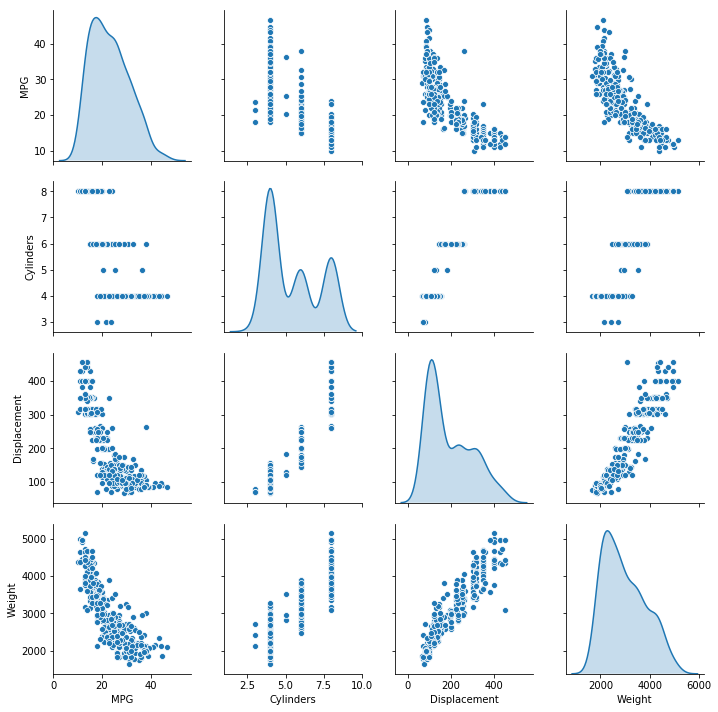

In [8]:
# 训练集中几对列的联合分布
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
# 整体的统计数据
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()  # train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
# 将目标值或“标签”与要素分开
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [11]:
# 标准化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
# 建立模型
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [13]:
model = build_model()

In [14]:
# 检查模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 试验模型
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.60630924],
       [0.40338123],
       [0.11330649],
       [0.68805397],
       [0.4913144 ],
       [0.07272617],
       [0.52754027],
       [0.02046716],
       [0.16026874],
       [0.778009  ]], dtype=float32)

In [16]:
# 训练模型
class PrintArrow(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('>', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintArrow()])


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [17]:
# 可视化模型的训练进度
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,7.731236,2.060370,7.731236,2.082388,0.945707,2.082388,995
996,8.039497,2.198004,8.039497,2.103009,0.951727,2.103009,996
997,8.272557,2.203817,8.272557,2.011809,0.926942,2.011809,997
998,8.165313,2.166816,8.165313,2.054557,0.944549,2.054557,998
999,8.579655,2.209690,8.579655,2.037035,0.953671,2.037035,999


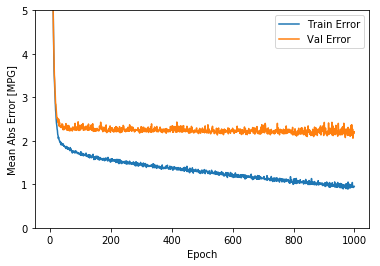

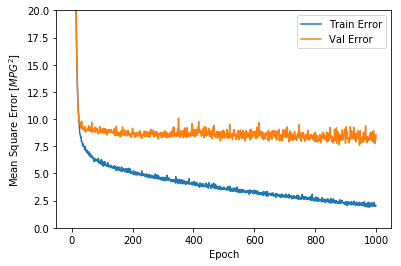

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.legend()
    plt.ylim([0,5])
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    plt.legend()
    plt.ylim([0,20])

plot_history(history)

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.13 MPG


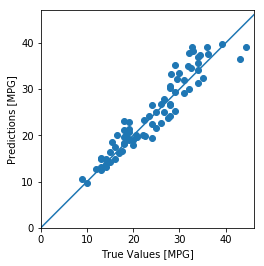

In [20]:
# 使用测试集中的数据预测MPG值
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

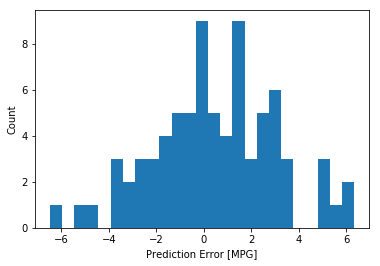

In [21]:
# 错误分布
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")